In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def make_Dataset(x_train, x_val, y_train, y_val, batch_size=32):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1,1)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, x_val_tensor,y_val_tensor

In [5]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tr_loss = 0

    model.train()
    for x,y in dataloader:
        x ,y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    tr_loss /= num_batches
    return tr_loss.item()

In [6]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()

    with torch.no_grad():
        x, y= x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred,y).item()
    return eval_loss, pred

In [7]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list) + 1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker='.')
    plt.plot(epochs, val_loss_list, label='val_err', marker='.')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
path='https://bit.ly/titanic_simple_csv'
data = pd.read_csv(path)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,Southampton
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,Cherbourg
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,Southampton
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,Southampton
4,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,Southampton


In [9]:
target= 'Survived'
features = ['Sex', 'Age', 'Fare']
x = data.loc[:,features]
y = data.loc[:,target]

In [10]:
x = pd.get_dummies(x, columns=['Sex'], drop_first=True)
x.head()

,Age,Fare,Sex_male
0,22.0,7.2500,True
1,38.0,71.2833,False
2,26.0,7.9250,False
3,35.0,53.1000,False
4,35.0,8.0500,True


In [11]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=.3)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

y_train = y_train.values
y_val = y_val.values

In [12]:
train_loader, x_val_ts, y_val_ts = make_Dataset(x_train, x_val, y_train, y_val, 32)

for x,y in train_loader:
    print(f'Shape of x [rows, columns]: {x.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of x [rows, columns]: torch.Size([32, 3])
Shape of y: torch.Size([32, 1]) torch.float32


In [13]:
n_feature = x.shape[1]

model = nn.Sequential(nn.Linear(n_feature,1),
                      nn.Sigmoid()
                      ).to(device)

In [14]:
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [15]:
epochs = 50
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f'Epoch {t+1}, train loss: {tr_loss:.4f}, val loss: {val_loss:.4f}')

Epoch 1, train loss: 0.6370, val loss: 0.6220
Epoch 2, train loss: 0.6178, val loss: 0.6049
Epoch 3, train loss: 0.5985, val loss: 0.5922
Epoch 4, train loss: 0.5880, val loss: 0.5815
Epoch 5, train loss: 0.5790, val loss: 0.5725
Epoch 6, train loss: 0.5692, val loss: 0.5646
Epoch 7, train loss: 0.5638, val loss: 0.5582
Epoch 8, train loss: 0.5592, val loss: 0.5523
Epoch 9, train loss: 0.5510, val loss: 0.5470
Epoch 10, train loss: 0.5450, val loss: 0.5427
Epoch 11, train loss: 0.5385, val loss: 0.5392
Epoch 12, train loss: 0.5390, val loss: 0.5354
Epoch 13, train loss: 0.5344, val loss: 0.5328
Epoch 14, train loss: 0.5328, val loss: 0.5302
Epoch 15, train loss: 0.5291, val loss: 0.5280
Epoch 16, train loss: 0.5251, val loss: 0.5260
Epoch 17, train loss: 0.5243, val loss: 0.5243
Epoch 18, train loss: 0.5238, val loss: 0.5233
Epoch 19, train loss: 0.5202, val loss: 0.5218
Epoch 20, train loss: 0.5212, val loss: 0.5210
Epoch 21, train loss: 0.5181, val loss: 0.5199
Epoch 22, train loss: 

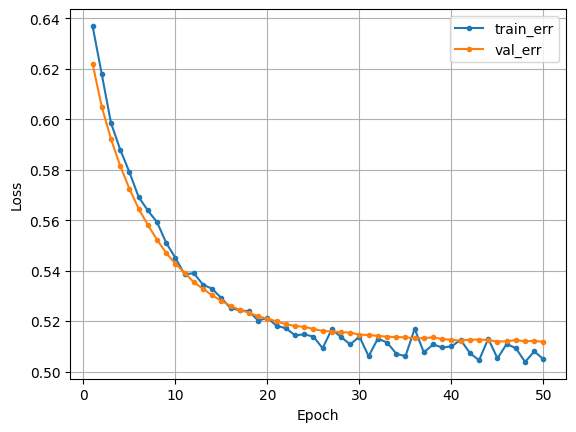

In [16]:
dl_learning_curve(tr_loss_list, val_loss_list)

In [17]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
print(pred.cpu().numpy()[:5])

[[0.6972948 ]
 [0.71263474]
 [0.8499707 ]
 [0.72958404]
 [0.21403155]]


# 이직 직원 예측

## Data preprocessing

In [19]:
path = 'https://bit.ly/attri_csv'

data = pd.read_csv(path)
data.head()

,Attrition,Age,Department,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,33,Research & Development,7,3,817,3,Male,3,Married,11691,0,No,11,0,14,3,4,13
1,0,35,Research & Development,18,2,1412,3,Male,4,Single,9362,2,No,11,0,10,2,3,2
2,0,42,Research & Development,6,3,1911,3,Male,1,Married,13348,9,No,13,1,18,3,4,13
3,0,46,Sales,2,3,1204,3,Female,1,Married,17048,8,No,23,0,28,2,3,26
4,1,22,Research & Development,4,1,593,3,Male,3,Single,3894,5,No,16,0,4,3,3,2


In [20]:
target = 'Attrition'
x = data.drop([target, 'EmployeeNumber'], axis=1)
y = data.loc[:, target]

print(x.shape)

(1175, 17)


## 가변수화

In [21]:
cat_cols = ['Department', 'Education', 'EnvironmentSatisfaction', 'Gender', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'WorkLifeBalance' ]

x = pd.get_dummies(x, columns=cat_cols, drop_first=True)
x.shape

(1175, 28)

## 데이터 스케일링 및 분할

In [22]:
# train, val 분할
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=.3)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

y_train = y_train.values
y_val = y_val.values

## 데이터 로더 준비

In [29]:
train_loader, x_val_ts, y_val_ts = make_Dataset(x_train,x_val,y_train, y_val, 32)

In [33]:
from torchsummary import summary
n_feature = x.shape[1]
model = nn.Sequential(nn.Linear(n_feature, 16), nn.ReLU(),
                      nn.Linear(16,8), nn.ReLU(),
                      nn.Linear(8,1), nn.Sigmoid()
                      ).to(device)

summary(model, input_size=(n_feature,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             464
              ReLU-2                   [-1, 16]               0
            Linear-3                    [-1, 8]             136
              ReLU-4                    [-1, 8]               0
            Linear-5                    [-1, 1]               9
           Sigmoid-6                    [-1, 1]               0
Total params: 609
Trainable params: 609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [35]:
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

## 학습

In [38]:
epochs = 50
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1} tr loss: {tr_loss:4f}, val loss: {val_loss:4f}')


Epoch 1 tr loss: 0.540895, val loss: 0.492264
Epoch 2 tr loss: 0.501854, val loss: 0.432074
Epoch 3 tr loss: 0.465815, val loss: 0.394585
Epoch 4 tr loss: 0.451083, val loss: 0.383172
Epoch 5 tr loss: 0.445473, val loss: 0.377336
Epoch 6 tr loss: 0.439396, val loss: 0.372981
Epoch 7 tr loss: 0.430370, val loss: 0.368066
Epoch 8 tr loss: 0.424333, val loss: 0.363343
Epoch 9 tr loss: 0.417866, val loss: 0.355752
Epoch 10 tr loss: 0.411276, val loss: 0.350559
Epoch 11 tr loss: 0.402221, val loss: 0.344847
Epoch 12 tr loss: 0.397040, val loss: 0.343272
Epoch 13 tr loss: 0.389327, val loss: 0.335170
Epoch 14 tr loss: 0.384687, val loss: 0.334593
Epoch 15 tr loss: 0.377108, val loss: 0.327269
Epoch 16 tr loss: 0.375130, val loss: 0.323832
Epoch 17 tr loss: 0.365752, val loss: 0.324032
Epoch 18 tr loss: 0.366561, val loss: 0.318916
Epoch 19 tr loss: 0.361220, val loss: 0.315566
Epoch 20 tr loss: 0.359773, val loss: 0.313065
Epoch 21 tr loss: 0.355125, val loss: 0.311921
Epoch 22 tr loss: 0.35

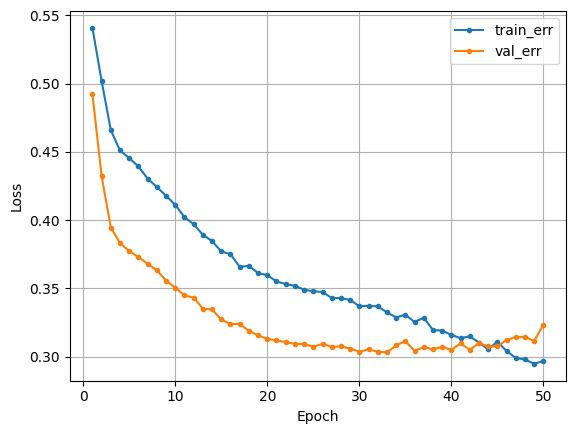

In [39]:
dl_learning_curve(tr_loss_list, val_loss_list)

## 검증평가

In [43]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

pred = np.where(pred.cpu().numpy() > .5, 1, 0)

In [44]:
print(classification_report(y_val_ts.cpu().numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       305
         1.0       0.66      0.44      0.53        48

    accuracy                           0.89       353
   macro avg       0.79      0.70      0.73       353
weighted avg       0.88      0.89      0.88       353



## Baseline Model

In [49]:
from torchsummary import summary

n_feature = x.shape[1]
model = nn.Sequential(nn.Linear(n_feature,1),
                      nn.Sigmoid()
                      ).to(device)

summary(model, input_size=(n_feature,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]              29
           Sigmoid-2                    [-1, 1]               0
Total params: 29
Trainable params: 29
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [50]:
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [51]:
epochs = 50

base_tr_loss_list, base_val_loss_list = [],[]
for t in range(epochs):
    base_tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    base_val_loss, _ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    base_tr_loss_list.append(base_tr_loss)
    base_val_loss_list.append(base_val_loss)

    print(f'Epoch: {t+1} base tr loss: {base_tr_loss:4f}, base val loss: {base_val_loss:4f}')

Epoch: 1 base tr loss: 0.713813, base val loss: 0.662706
Epoch: 2 base tr loss: 0.642615, base val loss: 0.592126
Epoch: 3 base tr loss: 0.588205, base val loss: 0.540261
Epoch: 4 base tr loss: 0.548734, base val loss: 0.500872
Epoch: 5 base tr loss: 0.521833, base val loss: 0.471878
Epoch: 6 base tr loss: 0.500538, base val loss: 0.451015
Epoch: 7 base tr loss: 0.488322, base val loss: 0.435649
Epoch: 8 base tr loss: 0.475846, base val loss: 0.424482
Epoch: 9 base tr loss: 0.469574, base val loss: 0.415596
Epoch: 10 base tr loss: 0.466396, base val loss: 0.408459
Epoch: 11 base tr loss: 0.457621, base val loss: 0.403495
Epoch: 12 base tr loss: 0.455837, base val loss: 0.399033
Epoch: 13 base tr loss: 0.452667, base val loss: 0.395285
Epoch: 14 base tr loss: 0.450258, base val loss: 0.392005
Epoch: 15 base tr loss: 0.446092, base val loss: 0.389654
Epoch: 16 base tr loss: 0.445372, base val loss: 0.387463
Epoch: 17 base tr loss: 0.443101, base val loss: 0.385201
Epoch: 18 base tr loss:

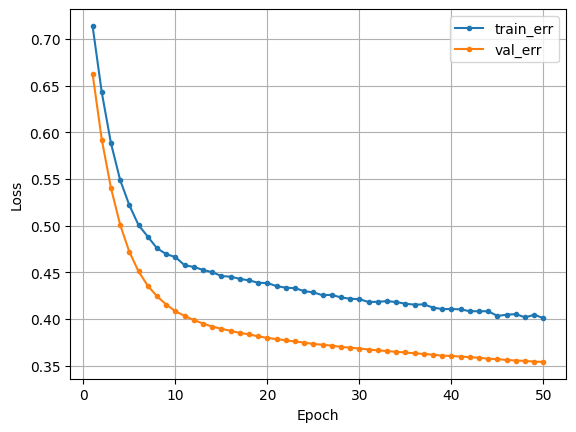

In [52]:
dl_learning_curve(base_tr_loss_list, base_val_loss_list)

In [53]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

pred = np.where(pred.cpu().numpy()>.5, 1,0)

pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [58]:
print(classification_report(y_val_ts.cpu().numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93       305
         1.0       0.00      0.00      0.00        48

    accuracy                           0.86       353
   macro avg       0.43      0.50      0.46       353
weighted avg       0.75      0.86      0.80       353



/home/mg/project/pytorch-10day/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mg/project/pytorch-10day/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mg/project/pytorch-10day/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me